In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from collections import deque

from utils import to_latex_table

In [2]:
FIGSIZE = (14,8)

In [3]:
rf = 7.85849419846496e-05

In [4]:
data = pd.read_pickle('..//data//clean_data.pkl')

In [5]:
class RollingSharpLSTM():
    
    def __init__(self, riskfree_rate, long_window=50, short_window=10, threshold=0.5):
        self.long_mem = deque(list(), long_window)
        self.short_mem = deque(list(), short_window)
        self.short_window = short_window
        self.long_window = long_window
        self.riskfree_rate = riskfree_rate
        self.log_swap = list()
        self.iter = 0
        self.threshold = threshold
        
    def __repr__(self):
        return str(self.long_mem)
        
    @staticmethod
    def calc_sharp(mem, rf):
        lm_df = pd.DataFrame(mem)
        res = (lm_df.mean(axis=0) - rf) / lm_df.std(axis=0)
        return res.fillna(0.1)
    
    def long_sharp(self):
        return self.calc_sharp(self.long_mem, self.riskfree_rate)
    
    def short_sharp(self):
        return self.calc_sharp(self.short_mem, self.riskfree_rate)
    
    def swap_memory(self):
        """Replacing old long term memory with short term"""
        self.long_mem = deque(list(self.short_mem), self.long_window)
        self.log_swap.append(self.iter)
        
    def calc_squared_distance(self, x):
        self.long_mem.append(x)
        self.short_mem.append(x)
        return np.mean((self.long_sharp() - self.short_sharp())**2)

    def pred(self, x):
        self.iter += 1
        dist = self.calc_squared_distance(x)
        if dist > self.threshold:
            self.swap_memory()
            
        return self.long_sharp()

In [6]:
def calc_tangency_portfolio(mu, covars, rf):
    ones, covars_inv = np.ones(len(mu)), np.linalg.inv(covars)

    risk_adjusted_mu = (mu - (rf * ones))
    
    numer = np.dot(covars_inv, risk_adjusted_mu)
    denom = np.dot(ones.T, numer)
    return numer / denom

In [7]:
rs_lstm = RollingSharpLSTM(rf, threshold=0.3, long_window=150, short_window=30)
res = list(map(rs_lstm.pred, np.array(data)))

In [8]:
pred = pd.DataFrame(res)
names = { key:val for key, val in enumerate(data.columns)}

In [9]:
pred.rename(names, inplace=True, axis=1)

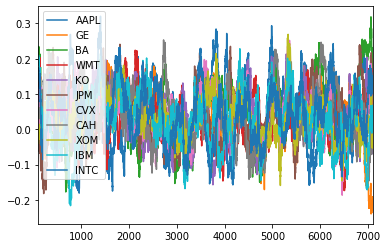

In [10]:
pred.iloc[100:].plot()

In [11]:
from functools import partial
def is_highest(x, row):
    if x == max(row):
        return 1
    else:
        return 0
    
def dummy_highest_val(row):
    
    return list(map(partial(is_highest, row=row), row))

In [12]:
highest_sharp_ratio = pred.apply(dummy_highest_val, axis=1, result_type='broadcast')

In [13]:
highest_sharp_ratio.set_index(data.index, inplace=True)

In [14]:
def _get_val(row):
    for ix, val in enumerate(row):
        if val == 1:
            return ix
        
        
hs_categorical = highest_sharp_ratio.apply(_get_val, axis=1)

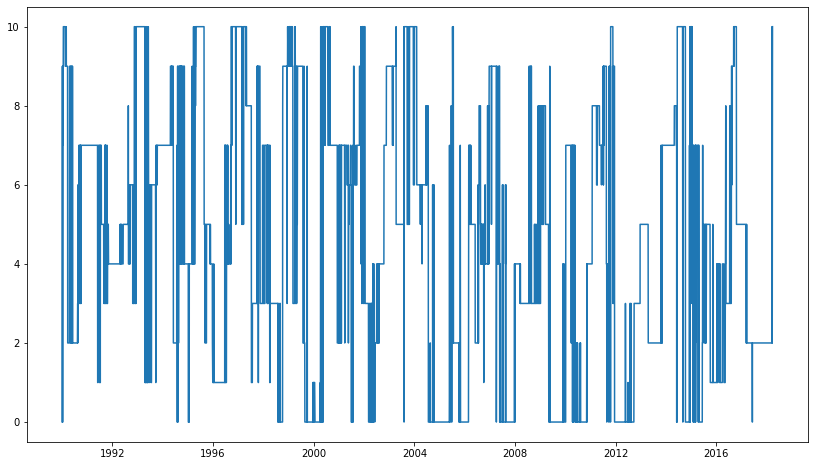

In [15]:
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.plot(hs_categorical)

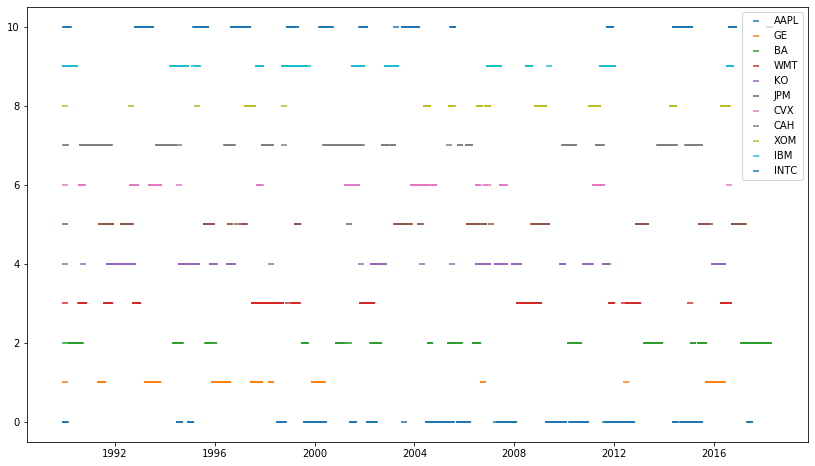

In [57]:
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
for ix, col in enumerate(highest_sharp_ratio.columns):
    ss = highest_sharp_ratio[col].loc[highest_sharp_ratio[col] == 1]
    ax.scatter(ss.index, ss*ix, label=str(col), marker='_')
    
ax.legend()

In [58]:
f.savefig('..//figures//highest_sharp_real_data.png')

In [100]:
stock_pick_portfolio = (highest_sharp_ratio * data).sum(axis=1)

In [18]:
def portfolio_performance(portfolio, rf):
    _mean, _std = np.mean(portfolio), np.std(portfolio)
    _sharp = (_mean - rf) / _std
    return _mean, _std, _sharp

In [19]:
perf_stock_pick = portfolio_performance(stock_pick_portfolio, rf)
perf_stock_pick

(0.0026266262768054175, 0.020283981853990395, 0.1256183994425878)

In [20]:
perf_best_port = portfolio_performance(data.max(axis=1), rf)
perf_best_port

(0.025147784267682206, 0.022845502089563836, 1.0973363258735092)

In [21]:
perf_apple = portfolio_performance(data['AAPL'], rf)
perf_apple

(0.0011126506411261155, 0.02824433407317918, 0.03661143847336853)

In [46]:
class InvestReturn():
    """portfolio pandas df or series"""
    
    def __init__(self, portfolio, start_value = 100):
        self.portfolio = portfolio
        self.start_value = start_value
        
    def run(self):
        self.result = list()
        
        assets = self.start_value
        
        self.result.append(assets)
        for r in self.portfolio:
        
            assets = assets * (1+r)
            self.result.append(assets)
            
        return pd.Series(self.result[1:], index=self.portfolio.index)
    
    def plot(self):
        d = self.run()
        plt.plot(d)
        
    def log_run(self):
        d = self.run()
        return np.log(d)

In [23]:
performance_stock_pick = InvestReturn(stock_pick_portfolio).run()

In [24]:
ix = 1000
tp_mean, tp_cov = data.iloc[0:ix].mean(axis=0), np.cov(data.iloc[0:ix].T)
tp_weights = calc_tangency_portfolio(tp_mean, tp_cov, rf)
tp_portfolio_1000_obs = pd.Series(np.dot(np.array(data), tp_weights), index=data.index, name='tangency_portfolio')

In [26]:
ix = 7013
tp_mean, tp_cov = data.iloc[0:ix].mean(axis=0), np.cov(data.iloc[0:ix].T)
tp_weights = calc_tangency_portfolio(tp_mean, tp_cov, rf)
tp_portfolio_full = pd.Series(np.dot(np.array(data), tp_weights), index=data.index, name='tangency_portfolio')

In [27]:
perf_tp_1000 = portfolio_performance(tp_portfolio_1000_obs, rf)
perf_tp_1000

(0.0005762204311380735, 0.018304114593739828, 0.027187083352484022)

In [28]:
perf_tp_full = portfolio_performance(tp_portfolio_full, rf)
perf_tp_full

(0.0007697012852044823, 0.01246325145042938, 0.05545233087598683)

In [112]:
analysis = [perf_stock_pick, perf_best_port, perf_apple, perf_tp_1000, perf_tp_full]
_index = ['rolling sharpe', 'perfect stock pick', 'apple', 'tangency portfolio (1000 obs)', 'tangency portfolio (all obs)']

In [113]:
performance_overview = pd.DataFrame(analysis, index = _index, columns =['Expected Return', 'Std', 'Sharpe Ratio'])

In [114]:
performance_overview

,Expected Return,Std,Sharpe Ratio
rolling sharpe,0.002627,0.020284,0.125618
perfect stock pick,0.025148,0.022846,1.097336
apple,0.001113,0.028244,0.036611
tangency portfolio (1000 obs),0.000576,0.018304,0.027187
tangency portfolio (all obs),0.000770,0.012463,0.055452


In [115]:
to_latex_table('..//tables//analysis_portfolio_performance', performance_overview, index=True, nr_decimals=5)

### Illustrating different portfolio

In [47]:
plot_stock_pick = InvestReturn(stock_pick_portfolio).log_run()
plot_perfect_pick = InvestReturn(data.max(axis=1)).log_run()
plot_apple = InvestReturn(data['AAPL']).log_run()
plot_tp_1000 = InvestReturn(tp_portfolio_1000_obs).log_run()
plot_tp_full = InvestReturn(tp_portfolio_full).log_run()

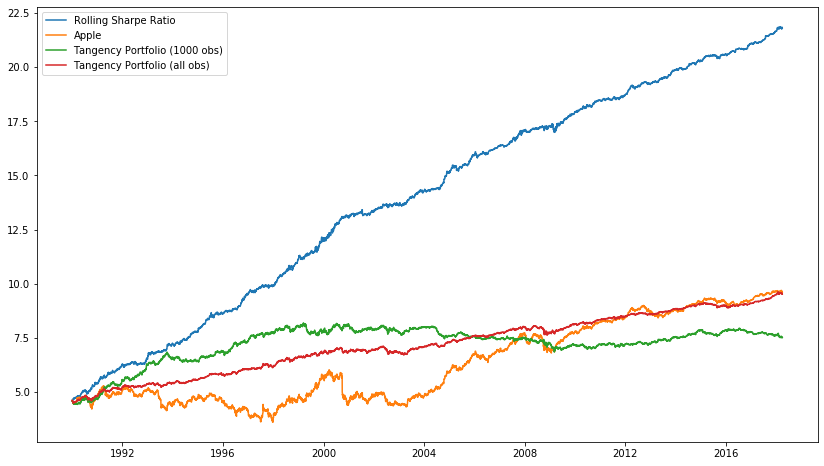

In [116]:
f, ax = plt.subplots(1,1, figsize=FIGSIZE)

ax.plot(plot_stock_pick, label='Rolling Sharpe Ratio')
#ax.plot(plot_perfect_pick, label = 'Perfect stock pick')
ax.plot(plot_apple, label = 'Apple')
ax.plot(plot_tp_1000, label = 'Tangency Portfolio (1000 obs)')
ax.plot(plot_tp_full, label = 'Tangency Portfolio (all obs)')
ax.legend()

In [117]:
f.savefig('..//figures//log_investment_experiment.png')

In [70]:
### Picking Stock with highest sharp
k = (data.mean() - rf) / data.std()
k.loc[k==max(k)]

AAPL    0.036609
dtype: float64

In [82]:
tt = highest_sharp_ratio.sum(axis=1)

In [95]:
InvestReturn(stock_pick_portfolio, start_value=1).run()[-1]**(1/30) -1

0.7749004884797586

In [92]:
InvestReturn(data['AAPL'], start_value=1).run()[-1]**(1/30) - 1

0.1819260703838217

In [118]:
InvestReturn(tp_portfolio_full, start_value=1).run()[-1]**(1/30) - 1

0.17827521261966783

# Confidence intervals

In [120]:
sim = np.random.normal(0.00263, 0.02028, size=(7013, 10000))

In [149]:
def calc_sim(loc, scale, t, n):
    sim = np.random.normal(loc, scale, size=(t, n))
    
    assets = np.ones(t)
    for i in range(t):
        assets = assets*(1+sim[:,i])
        
    return np.log(assets)

In [157]:
rs_sims = calc_sim(0.00263, 0.02028, 7013, 10000)

In [151]:
apple_sims = calc_sim(0.00111, 0.02824, 7013, 10000)

In [152]:
tp_full_sims = calc_sim(0.00077, 0.01246, 7013, 10000)

In [153]:
tp_1000_sims = calc_sim(0.00058, 0.01830, 7013, 10000)

In [158]:
res = {
    'rolling sharpe' : rs_sims,
    'apple' : apple_sims,
    'tangency portfolio full' : tp_full_sims,
    'tangency portfolio (1000 obs)' : tp_1000_sims
}


In [159]:
d = pd.DataFrame(res)

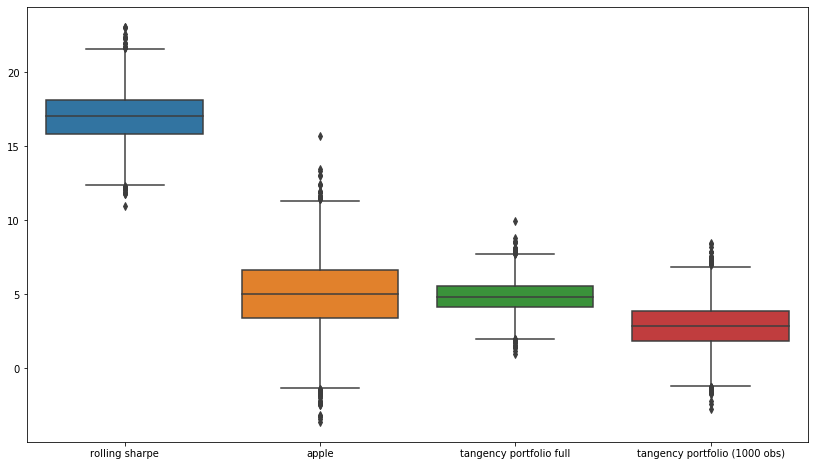

In [160]:
f, ax = plt.subplots(1,1,figsize=FIGSIZE)
ax = sbn.boxplot(data = d)

In [161]:
f.savefig('..//figures//boxplot_monte_carlo.png')